# Wine Classifications by Reviews

There's so many wines out there today, and often times a trip to the grocery store to pick up a quick drink to go with dinner can take longer than expected. Even when you know the type of wine you like, there's so many different wineries, and let's not even start on the years. Even wanting to try something new can be daunting, what if you spend $15 dollars just to find out you can't stand more than one sip?! 

Luckily, there's sommeliers in the world... unluckily, they probably aren't hanging around your local grocery or liquor store. Classification beyond the wine types could prove valuable in this case! Using machine learning and hefty data source of sommelier's reviews, I plan to use **LSA** text classification to find groups of wine, possibly with more in common than just being the same type!

## Vectorization & SVD for LSA

Now that we have cleaned up description data, we can begin the process of completing an LSA analysis. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
wine=pd.read_csv("D:\Practicum2\data\WineClean.csv")

As a reminder, here's what the dataset looks like with our cleaned up description as the end. We've removed a lot chaff, including our own stopwords related to wine that won't add to the topics. 

In [3]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery,clean_desc
0,0,United States of America,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,this tremendous varietal hails from oakville a...
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas blackberry cassis softened sweeten...
2,2,United States of America,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,watson honors memory once made mother this tre...
3,3,United States of America,"This spent 20 months in 30% new French oak, an...",Reserve,96,65,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,this spent months french incorporates fruit fr...
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,this from gude named after highest point viney...


We can now vectorize the clean description, or turn it it into a bag of words. Essentially our bag of words will have 1000 columns accross the top with the id as the record. 

In [4]:
Vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms, cause that's a lot of words otherwise 
max_df = 0.5, 
smooth_idf=True)

In [5]:
X = vectorizer.fit_transform(wine['clean_desc'])

In [6]:
X.shape # check shape of the document-term matrix

(97850, 1000)

In [56]:
X

<97850x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1458384 stored elements in Compressed Sparse Row format>

X is our vectorized clean_desc now. 

Before we start building the model, we should consider how many topics we want created. A topic could be similar to the type of wine, so let's check how many of those there are in total. 

In [7]:
wine.agg({'variety':pd.Series.nunique})

variety    632
dtype: int64

That's a lot of wine types... and we want to find wines that are similar, not necessarily just because they are the same type. Let's try a couple different sizes and use the results to understand whether they are a good fit. In the below commands, n_components is equal to how many topics will be created. Once we fit the model to the vectorized data (X), we can use the explained variance to see how much of the data fits into the model. This method of determining groups was devised from George's (2020) methods.

In [8]:
svd_model10 = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

In [9]:
svd_model25 = TruncatedSVD(n_components=25, algorithm='randomized', n_iter=100, random_state=122)

In [10]:
svd_model50 = TruncatedSVD(n_components=50, algorithm='randomized', n_iter=100, random_state=122)

In [11]:
svd_model10.fit(X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=122, tol=0.0)

10 topics only fits about 6% of the data... we definitely need more!

In [19]:
svd_model10.explained_variance_ratio_.sum()

0.06226255173291435

In [12]:
svd_model25.fit(X)

TruncatedSVD(algorithm='randomized', n_components=25, n_iter=100,
             random_state=122, tol=0.0)

In [20]:
svd_model25.explained_variance_ratio_.sum()

0.11916143932544133

25 topics takes of up to 12%, which still isn't great. 

In [13]:
svd_model50.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=100,
             random_state=122, tol=0.0)

In [26]:
svd_model50.explained_variance_ratio_.sum()

0.19320955166887363

19% is still pretty low, so let's make a really big model, and hopefully pare down from there.

In [29]:
svd_model500 = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=100, random_state=122)

In [30]:
svd_model500.fit(X)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=100,
             random_state=122, tol=0.0)

In [32]:
svd_model500.explained_variance_ratio_.sum()

0.7597558916963185

76% is pretty good! However the model is pretty big, much higher than the recommended 100 (Pedregosa et al., 2011), and other programs recommend an explained variance of around 50% (LSA, 2015).

500 components might be overkill if we aim for the recommended 50%. With the below cumulative sum, we can see that we reach this 50% mark at 219 groups. 

In [33]:
(svd_model500.explained_variance_ratio_.cumsum() <= 0.5).sum()

219

In [34]:
import matplotlib.pyplot as plt

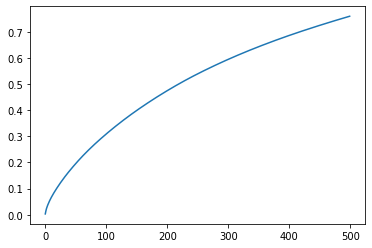

In [36]:
plt.plot(range(svd_model500.explained_variance_ratio_.shape[0]), svd_model500.explained_variance_ratio_.cumsum())

If we plot it we can see it does sort of start to slow down right around 250. So let's round up to 250, and use a slightly smaller model with that many components. 

In [38]:
svd_model250 = TruncatedSVD(n_components=250, algorithm='randomized', n_iter=100, random_state=122)

In [39]:
svd_model250.fit(X)

TruncatedSVD(algorithm='randomized', n_components=250, n_iter=100,
             random_state=122, tol=0.0)

In [40]:
svd_model250.explained_variance_ratio_.sum()

0.5382649482698851

54% of the variance! Let's keep going with this model.

In [41]:
terms = vectorizer.get_feature_names()

Let's take a look at the topics, and we can see there are interesting combinations, but they sort of make sense if you've read a wine review before. "Vanilla, soft, creamy" in topic 16 sounds like a combination that would taste good if describing a dessert or a wine (at least to me). 

In [70]:
for i, comp in enumerate(svd_model250.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")
        
#(Joshi, 2018)

Topic 0: 
fruit
 
tannins
 
acidity
 
cherry
 
aromas
 
black
 
ripe
 
Topic 1: 
apple
 
citrus
 
crisp
 
fresh
 
white
 
peach
 
acidity
 
Topic 2: 
acidity
 
fruits
 
ripe
 
rich
 
wood
 
tannins
 
aging
 
Topic 3: 
sweet
 
soft
 
cherry
 
simple
 
cherries
 
vanilla
 
little
 
Topic 4: 
fresh
 
cherry
 
light
 
fruity
 
soft
 
acidity
 
bright
 
Topic 5: 
soft
 
sweet
 
ripe
 
berry
 
fruits
 
plum
 
wood
 
Topic 6: 
green
 
herbal
 
palate
 
plum
 
sweet
 
apple
 
nose
 
Topic 7: 
fruit
 
light
 
herbal
 
tart
 
berry
 
raspberry
 
barrel
 
Topic 8: 
soft
 
fruit
 
black
 
apple
 
light
 
tannins
 
ripe
 
Topic 9: 
sweet
 
black
 
cherry
 
acidity
 
tannins
 
firm
 
white
 
Topic 10: 
cherry
 
ripe
 
raspberry
 
vanilla
 
acidity
 
plum
 
palate
 
Topic 11: 
blackberry
 
green
 
chocolate
 
dark
 
apple
 
cherry
 
citrus
 
Topic 12: 
tannins
 
firm
 
apple
 
cherry
 
green
 
soft
 
years
 
Topic 13: 
ripe
 
white
 
blackberry
 
berry
 
acidity
 
fruit
 
tannic
 
Topic 14: 
tannins


Topic 151: 
core
 
apricot
 
lean
 
sweetness
 
stone
 
minerality
 
toasty
 
Topic 152: 
caramel
 
lean
 
candied
 
oaky
 
core
 
easy
 
opens
 
Topic 153: 
apricot
 
minerality
 
high
 
earth
 
make
 
cinnamon
 
savory
 
Topic 154: 
forward
 
acids
 
blueberry
 
silky
 
come
 
powerful
 
grapes
 
Topic 155: 
powerful
 
aged
 
feels
 
french
 
months
 
minerality
 
price
 
Topic 156: 
powerful
 
savory
 
silky
 
caramel
 
food
 
core
 
herbs
 
Topic 157: 
gives
 
high
 
silky
 
drinking
 
grapes
 
caramel
 
quality
 
Topic 158: 
caramel
 
come
 
alcohol
 
mocha
 
pleasant
 
sweetness
 
spices
 
Topic 159: 
warm
 
rounded
 
minerality
 
gives
 
dusty
 
generous
 
powerful
 
Topic 160: 
earth
 
spices
 
pure
 
powerful
 
dusty
 
exotic
 
high
 
Topic 161: 
lean
 
gives
 
comes
 
strong
 
acids
 
tangy
 
right
 
Topic 162: 
pure
 
toasty
 
cedar
 
sour
 
acids
 
candied
 
bitter
 
Topic 163: 
gives
 
taste
 
savory
 
opens
 
concentration
 
forward
 
toasty
 
Topic 164: 
strong
 
comes
 

shape shows the number of topics (250) by the number of words (1000 aka the top 1000 words in the dataset)

In [62]:
svd_model250.components_  #.shape

array([[ 0.01039757,  0.01966238,  0.02070914, ...,  0.01035195,
         0.02180794,  0.02378933],
       [ 0.0016983 ,  0.00401328, -0.00206753, ..., -0.00156704,
         0.04787956,  0.05167842],
       [-0.01245832, -0.01145417, -0.02617884, ...,  0.00504208,
         0.00256769, -0.01103884],
       ...,
       [ 0.0026308 ,  0.02551964, -0.01248564, ..., -0.00616064,
         0.0801006 ,  0.02676677],
       [-0.00411548, -0.00823215, -0.01490291, ..., -0.00179852,
         0.00593777,  0.01032612],
       [-0.01027431,  0.00179578,  0.00939384, ...,  0.00551281,
        -0.04188701, -0.03393735]])

In [59]:
svd_model250.singular_values_.shape

(250,)

In [61]:
svd_model250.shape

AttributeError: 'TruncatedSVD' object has no attribute 'shape'

In [ ]:
#https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn


In [69]:
svd_model250.inverse_transform(X.toarray())

ValueError: shapes (97850,1000) and (250,1000) not aligned: 1000 (dim 1) != 250 (dim 0)

In [74]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [75]:
vectorizer.vocabulary_.get('vanilla')

945